# Universidade Federal do Rio Grande do Norte


## Programa de Pós-Graduação em Engenharia Elétrica e de Computação
## EEC1509 - Aprendizagem de Máquina


# Group

## João Lucas Correia Barbosa de Farias

## Júlio Freire Peixoto Gomes


# Project 2 - Traffic Sign Recognition


## About the Project
This project is divided in 6 files including this one, where each one represents one step in the process of deploying a machine learning algorithm. In this case, we chose a Neural Network algorithm as Classifier. The goal is to explore learning, generalization and batch-normalization techniques and compare results.

The dataset has over 50k images of traffic signs. Our goal is to predict which sign a specific image refers to.


### The details about the dataset are shown below.

The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011.

*   Single-image, multi-class classification problem
*   More than 40 classes
*   More than 50,000 images in total
*   Large, lifelike database

For more information, visit:

https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Also, for each class, that is a respective shape, color and sign id's. They are describred as follows:



1.   Shape ID
  *   0: red
  *   1: blue
  *   2: yellow
  *   3: white
2.   Color ID
  *   0: triangle
  *   1: circle
  *   2: diamond
  *   3: hexagon
  *   4: inverse-triangle
3.   Sign ID
  *   float: value according to Ukranian Traffic Rule

## The dataset was taken from Kaggle:
https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

# 1.0 Install and Load Libraries


In [ ]:
%%capture
!pip install wandb

In [ ]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import os

import h5py
from PIL import Image

# 2.0 EDA - Exploratory Data Analysis

In this step, we perform an exploratory data analysis, that is, analysing the overall trends and possible flaws of the dataset. By flaw we mean repeated lines, missing values etc. After doing the EDA, we will fix any issues we find in the preprocessing stage. **However, our dataset is composed just by images, so we cannot analyze the mean or standard deviation, the only characteristcs that are possible to see are the balance of classes and if there are duplicated images or not.**

**Another aspect of this dataset is the absence of anomalies. Hence, we decided to gather EDA and initial preprocessing in this file. The other part of the preprocessing is perfomed before the training, in the pipeline.**

## 2.1 Login to Weights & Biases

In [ ]:
# login to wandb
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 2.2 Download raw_data from wandb

In [ ]:
# initiate a run, syncing all steps taken on the notebook with wandb
run = wandb.init(project="traffic_sign_recognition", save_code=True)

wandb: Currently logged in as: jotafarias (ppgeec-ml-jj). Use `wandb login --relogin` to force relogin


In [ ]:
# download latest version of the artifacts raw_data_train.h5 and
# raw_data_train_labels.csv

artifact_wandb_train = run.use_artifact("ppgeec-ml-jj/traffic_sign_recognition/raw_data_train.h5:latest")
artifact_wandb_labels = run.use_artifact("ppgeec-ml-jj/traffic_sign_recognition/raw_data_train_labels.csv:latest")

In [ ]:
# creating variables with artifact names to facilitate the usage of 
# the functions

artifact_name_train = "preprocessed_data_train.h5"
artifact_name_train_labels = "preprocessed_data_train_labels.csv"

artifact_type="clean_data"
artifact_description="Data After Preprocessing"

In [ ]:
# create variables with artifacts
raw_train = artifact_wandb_train.file()
raw_train_labels = artifact_wandb_labels.file()

In [ ]:
# convert data into numpy array
raw_train_labels_path = raw_train_labels
raw_train_labels = np.loadtxt(raw_train_labels, delimiter=',')

In [ ]:
raw_train

'./artifacts/raw_data_train.h5:v0/raw_data_train.h5'

In [ ]:
image_data = []

with h5py.File(raw_train, 'r') as hf:
  images = list(hf.keys())
  for img in images:
    data = hf[img]
    data_array = np.array(data)
    image_data.append(np.array(data_array))

image_data = np.array(image_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
print(image_data.shape)

(11755,)


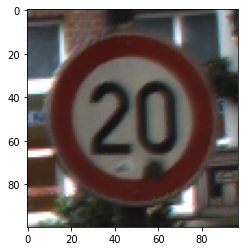

In [ ]:
plt.imshow(image_data[60])
plt.show() 

Testing if there are duplicates. We can see that there are no duplicates.

In [ ]:
duplicated = 0
i_array = []
j_array = []

for i in range(image_data.shape[0]-1):
  for j in range(i+1, image_data.shape[0]):
    if np.array_equal(image_data[i], image_data[j]):
      duplicated += 1
      i_array.append(i)
      j_array.append(j)

print(f"duplicated: {duplicated}")
print(f"i_array: {i_array}")
print(f"j_array: {j_array}")

duplicated: 0
i_array: []
j_array: []


Now, we will plot the histogram of the labels, that is, how many images there are for each possible class.

We can see the train set is a bit imbalanced, but even so there are 60 images of each class. We hope that is enough to provide good classification.

In [ ]:
print(f"raw_train_labels.dtype: {raw_train_labels.dtype}")
raw_train_labels = raw_train_labels.astype(int)
print(f"raw_train_labels.dtype: {raw_train_labels.dtype}")

raw_train_labels.dtype: float64
raw_train_labels.dtype: int64


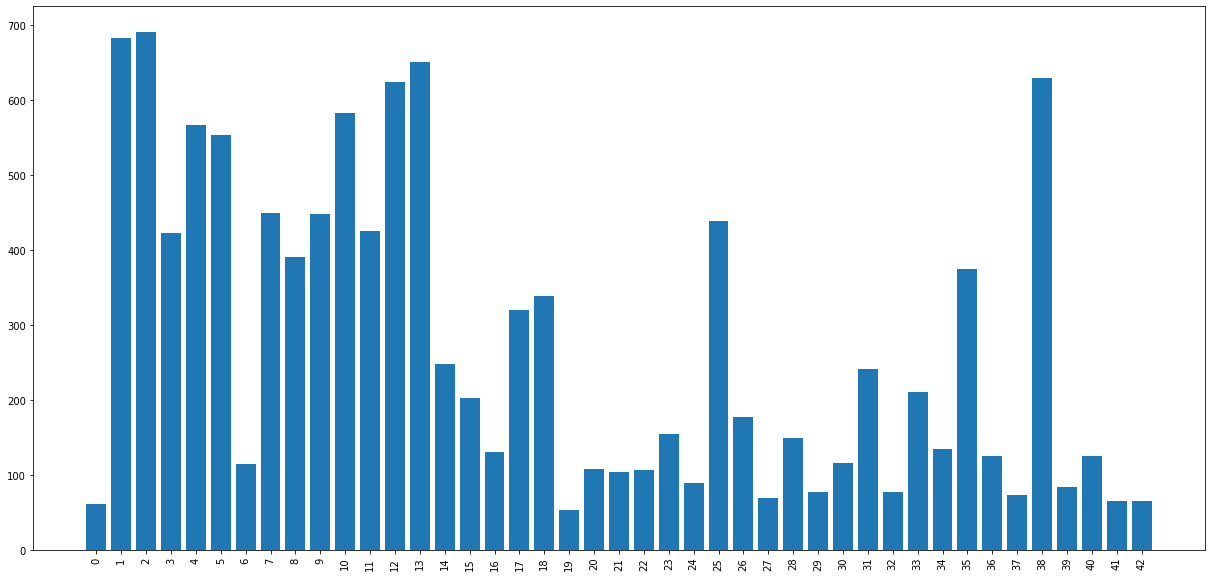

In [ ]:
NUM_LABELS = len(np.unique(raw_train_labels))
NUM_SAMPLES = len(raw_train_labels)

sign_class = np.arange(0, NUM_LABELS)
num_images_in_class = np.zeros(NUM_LABELS)

for i in range(NUM_SAMPLES):
  num_images_in_class[raw_train_labels[i]] += 1

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(sign_class, num_images_in_class)
plt.xticks(sign_class, rotation='vertical')
plt.show()

In [ ]:
print(f"raw_train: {raw_train}")
print(f"raw_train_labels_path: {raw_train_labels_path}")

raw_train: ./artifacts/raw_data_train.h5:v0/raw_data_train.h5
raw_train_labels_path: ./artifacts/raw_data_train_labels.csv:v0/raw_data_train_labels.csv


Uploading preprocessed files to W&B.
Since there was no need to modify the data, we just send back the data we downloaded from W&B but with another name and type: preprocessed_data.

In [ ]:
!cp $raw_train $artifact_name_train
!cp $raw_train_labels_path $artifact_name_train_labels

In [ ]:
print(os.path.getsize(raw_train))
print(os.path.getsize(artifact_name_train))
print(os.path.getsize(raw_train_labels_path))
print(os.path.getsize(artifact_name_train_labels))

114189890
114189890
30884
30884


In [ ]:
# uploading a new artifact to wandb using the variables created earlier
artifact_train = wandb.Artifact(name=artifact_name_train,
                          type=artifact_type,
                          description=artifact_description)
artifact_train.add_file(artifact_name_train)


artifact_train_labels = wandb.Artifact(name=artifact_name_train_labels,
                          type=artifact_type,
                          description=artifact_description)
artifact_train_labels.add_file(artifact_name_train_labels)

<ManifestEntry digest: 3AXzTUIGH4ZqLF7ePkFfqQ==>

In [ ]:
# uploading artifact to wandb
run.log_artifact(artifact_train)
run.log_artifact(artifact_train_labels)

In [ ]:
run.finish()